In [1]:
import torch
from torchvision import datasets, transforms

from neural_blueprints.architectures.autoencoder import VariationalAutoEncoder
from neural_blueprints.config.architectures import AutoEncoderConfig
from neural_blueprints.config.components.composite import EncoderConfig, DecoderConfig
from neural_blueprints.config.components.core import ConvLayerConfig, DenseLayerConfig, ReshapeLayerConfig, FlattenLayerConfig
from neural_blueprints.config.utils import TrainerConfig
from neural_blueprints.utils import Trainer, get_device, image_plot

import logging
logging.basicConfig(
    level=logging.INFO,  # or DEBUG if you want even more detail
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 7.22MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 292kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.96MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [3]:
latent_dim = 40

vae_config = AutoEncoderConfig(
    encoder_config=EncoderConfig(
        layer_configs=[
            ConvLayerConfig(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1, dim=2),     # 64x28x28 → 64x14x14
            ConvLayerConfig(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, dim=2),    # 64x14x14 → 64x7x7
            FlattenLayerConfig(),                                                                           # 64x7x7 → 64*7*7
            DenseLayerConfig(input_dim=64*7*7, output_dim=512),                                             # 64 * 7 * 7 → 512
            DenseLayerConfig(input_dim=512, output_dim=latent_dim*2)                                        # 512 → latent_dim * 2 (mean + logvar)
        ]
    ),
    decoder_config=DecoderConfig(
        layer_configs=[
            DenseLayerConfig(input_dim=latent_dim, output_dim=512),                                                                             # latent → 512
            DenseLayerConfig(input_dim=512, output_dim=64*7*7),                                                                                 # 512 → 64 * 7 * 7
            ReshapeLayerConfig(shape=(64,7,7)),                                                                                                 # reshape to (64,7,7)
            ConvLayerConfig(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1, dim=2),                      # 7x7→14x14
            ConvLayerConfig(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1, activation='sigmoid', dim=2)  # 14x14→28x28
        ]
    )
)

model = VariationalAutoEncoder(vae_config)
model.blueprint()

VariationalAutoEncoder(
  (encoder): Encoder(
    (network): Sequential(
      (0): Conv2dLayer(
        (conv): Sequential(
          (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): NormalizationLayer(
            (network): Identity()
          )
          (2): ReLU()
        )
      )
      (1): Conv2dLayer(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): NormalizationLayer(
            (network): Identity()
          )
          (2): ReLU()
        )
      )
      (2): FlattenLayer(
        (flatten): Flatten(start_dim=1, end_dim=-1)
      )
      (3): DenseLayer(
        (linear): Linear(in_features=3136, out_features=512, bias=True)
        (normalization): NormalizationLayer(
          (network): Identity()
        )
        (activation): Identity()
      )
      (4): DenseLayer(
        (linear): Linear(in_features=512, out_features=80, bias=True)
        (normalizat

AutoEncoderConfig(encoder_config=EncoderConfig(layer_configs=[ConvLayerConfig(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=None, dilation=1, groups=1, bias=True, norm=None, activation='relu', dim=2), ConvLayerConfig(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=None, dilation=1, groups=1, bias=True, norm=None, activation='relu', dim=2), FlattenLayerConfig(), DenseLayerConfig(input_dim=3136, output_dim=512, normalization=None, activation=None), DenseLayerConfig(input_dim=512, output_dim=80, normalization=None, activation=None)], final_activation=None), decoder_config=DecoderConfig(layer_configs=[DenseLayerConfig(input_dim=40, output_dim=512, normalization=None, activation=None), DenseLayerConfig(input_dim=512, output_dim=3136, normalization=None, activation=None), ReshapeLayerConfig(shape=(64, 7, 7)), ConvLayerConfig(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1, dilation=

In [ ]:
trainer = Trainer(
    config=TrainerConfig(
        learning_rate=1e-3,
        weight_decay=1e-5,
        batch_size=32,
        early_stopping_patience=1,
        save_weights_path="./models/vae_mnist.pth",
        criterion="vae_loss",
        optimizer='adam'
    ),
    model=model
)
trainer.train(train_dataset=train_dataset, val_dataset=test_dataset, epochs=20)

2025-12-20 12:18:55,795 - neural_blueprints.utils.trainer - INFO - Trainer initialized on device: cpu
Training Epochs:   0%|          | 0/20 [00:54<?, ?epoch/s]


KeyboardInterrupt: 

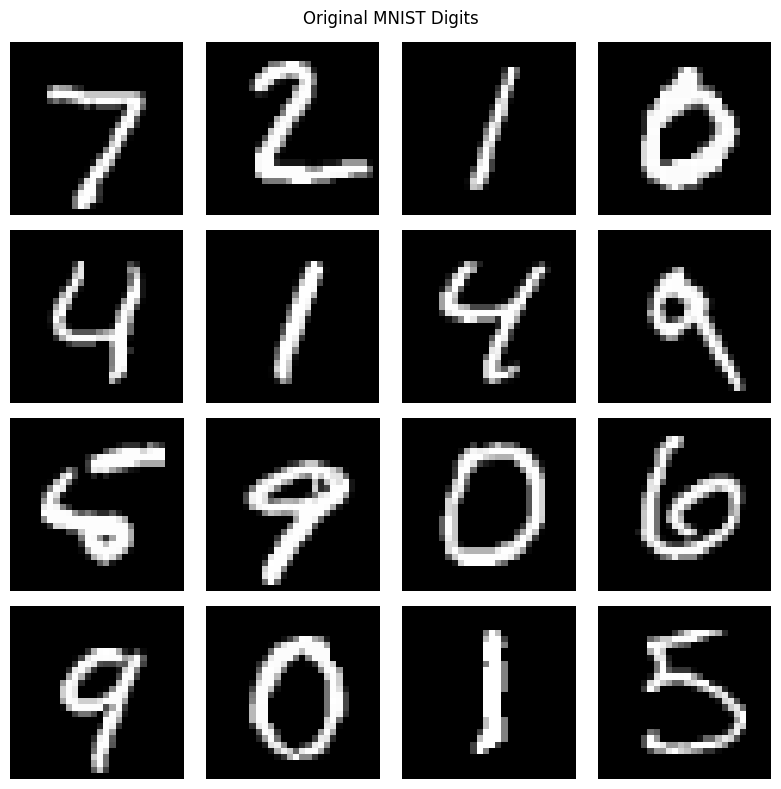

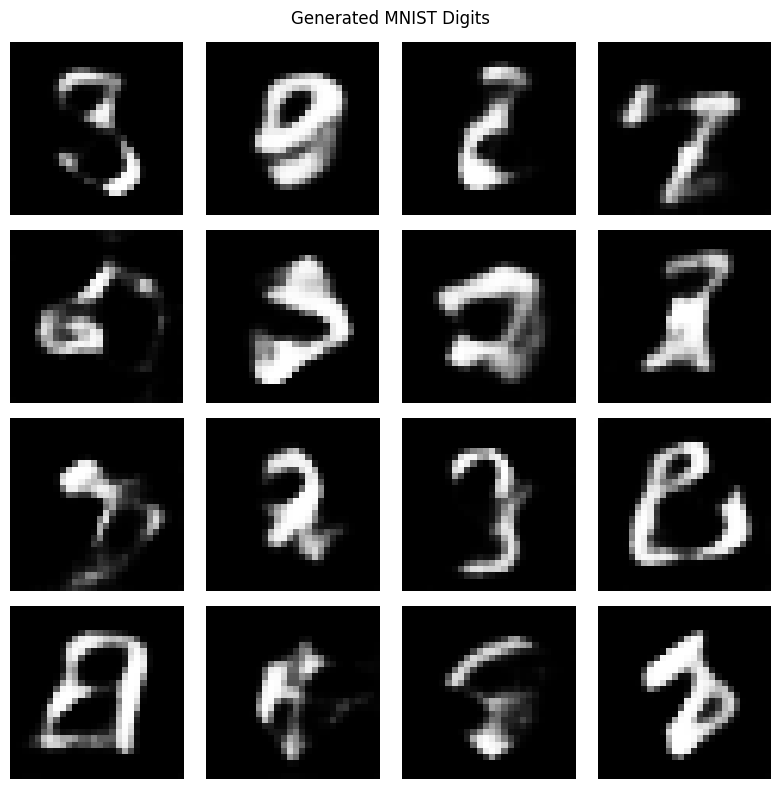

In [ ]:
model.eval()
with torch.no_grad():
    samples = model.decode(torch.randn(16, latent_dim).to(get_device())).cpu()
    samples = samples.permute(0, 2, 3, 1)  # Convert from (N, C, H, W) to (N, H, W, C)

image_plot(images=test_dataset.data[:16].unsqueeze(-1).float()/255.0, title="Original MNIST Digits", cols=4)
image_plot(images=samples, title="Generated MNIST Digits", cols=4)